
# University Accountability Ordinance (UAO) — Midterm Notebook
**Course:** CS506 Data Science (Spring 2025)  
**Client:** Councilor Liz Breadon’s Office  
**Notebook generated:** 2025-10-27 22:08

This notebook is the working artifact for the **midterm deliverables**:
- preliminary visualizations (EDA),
- detailed data processing description (with executable steps),
- modeling methods prototyped so far,
- preliminary results.

> Tip: Keep cells concise and add short markdown notes above each cell describing why the step is needed and what changed.


## 1. Setup & Configuration

In [9]:

# ==== Environment Checks & Imports ====
# If a package import fails, install it locally (e.g., `pip install pandas scikit-learn pyproj shapely`).
# Keep your environment pinned via requirements.txt for reproducibility.

import sys
import os
import math
import json
import pathlib
from typing import List, Dict, Tuple

# Core DS stack
import numpy as np
import pandas as pd

# Viz (follow course rules: use matplotlib for charts)
import matplotlib.pyplot as plt

# Modeling
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
except Exception as e:
    print('scikit-learn not available yet. Install it if you plan to run the modeling cells.')
    print(e)

# GIS helpers (optional, comment out if unavailable)
try:
    import geopandas as gpd
except Exception as e:
    print('geopandas not available (optional).')
    print(e)

# Paths
PROJECT_ROOT = pathlib.Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
CLEAN_DIR = DATA_DIR / 'cleaned'
VIZ_DIR = PROJECT_ROOT / 'visualizations'

for d in [DATA_DIR, RAW_DIR, CLEAN_DIR, VIZ_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Data directories created (if missing).')


geopandas not available (optional).
No module named 'geopandas'
Project root: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks
Data directories created (if missing).


## 2. Project Constants & Links

In [16]:

# === Official data sources (update if your team keeps copied snapshots in Drive) ===
URLS = {
    "violations": "https://data.boston.gov/api/3/action/datastore_search?resource_id=800a2663-1d6a-46e7-9356-bedb70f5332c&limit=50000",
    "requests_311": "https://data.boston.gov/api/3/action/datastore_search?resource_id=2968e2c0-d479-49ba-a884-4ef523ada3c0&limit=50000",  # check resource_id for 311
    "sam_addresses": "https://data.boston.gov/api/3/action/datastore_search?resource_id=4d01b43b-49f2-4e56-bc1b-cb7738eae6b2&limit=50000", # verify latest SAM resource
    "assessments": "https://data.boston.gov/api/3/action/datastore_search?resource_id=0625b6ca-7f79-4e0f-bb55-9d4a63f877f8&limit=50000",   # property assessment example id
    # Student Housing Reports (UAO): typically provided via client/drive — place CSVs in data/raw/uao/
}

DATA_FILES = {
    "violations": RAW_DIR / "violations_2016_2024.csv",
    # Add others when ready:
    # "311": RAW_DIR / "requests311_2016_2024.csv",
    # "assessments": RAW_DIR / "assessments_2024.csv",
}

# Years of interest
YEARS = list(range(2016, 2025))
print("Configured local data files:")
for name, path in DATA_FILES.items():
    print(f" - {name}: {path}")
print('Configured data URLs (verify resource_ids in your environment).')


Configured local data files:
 - violations: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw/violations_2016_2024.csv
Configured data URLs (verify resource_ids in your environment).


## 3. Data Acquisition

In [ ]:

# === Downloader utilities (CKAN-style API) ===
import urllib.request
import urllib.error

def fetch_ckan_json(url: str) -> dict:
    try:
        with urllib.request.urlopen(url) as resp:
            return json.loads(resp.read().decode('utf-8'))
    except urllib.error.URLError as e:
        print('Fetch failed:', url, e)
        return {}

def records_to_df(payload: dict, key: str = 'result') -> pd.DataFrame:
    if not payload:
        return pd.DataFrame()
    result = payload.get(key, {})
    recs = result.get('records', [])
    return pd.DataFrame(recs)

# Example: pull a small sample to get schema; for full pulls consider paging (offset/limit).
violations_sample = records_to_df(fetch_ckan_json(URLS['violations']))
print('Violations sample shape:', violations_sample.shape)
violations_sample.head()



## 4. Load Local Snapshots (Preferred for Reproducibility)
Place raw CSV extracts in `data/raw/` first (e.g., exported from the portal or provided by the client).
Name suggestions (adjust to your files):
- `violations_2016_2024.csv`
- `requests311_2016_2024.csv`
- `assessments_2024.csv`
- `sam_addresses.csv`
- `uao_students_2016_2024.csv`


In [20]:
from pathlib import Path

print("RAW_DIR:", RAW_DIR)
print("Files in RAW_DIR:")
for p in sorted(RAW_DIR.glob("*")):
    print(" -", p.name)

RAW_DIR: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw
Files in RAW_DIR:
 - violations_2016_2024.csv


In [23]:

# Template loaders — update filenames to your actual snapshots
def load_csv_safe(path: pathlib.Path, **kwargs) -> pd.DataFrame:
    if not path.exists():
        print(f'[WARN] Missing file: {path}')
        return pd.DataFrame()
    try:
        df = pd.read_csv(path, **kwargs)
        print(f'[OK] Loaded {path.name}:', df.shape)
        return df
    except Exception as e:
        print(f'[ERR] Could not load {path}:', e)
        return pd.DataFrame()

df_viol = load_csv_safe(RAW_DIR / 'violations_2016_2024.csv', low_memory=False)
df_311  = load_csv_safe(RAW_DIR / 'requests311_2016_2024.csv', low_memory=False)
df_assess = load_csv_safe(RAW_DIR / 'assessments_2024.csv', low_memory=False)
df_sam = load_csv_safe(RAW_DIR / 'sam_addresses.csv', low_memory=False)
df_uao = load_csv_safe(RAW_DIR / 'uao_students_2016_2024.csv', low_memory=False)

df_viol.head()
df_viol.info()



[OK] Loaded violations_2016_2024.csv: (16953, 25)
[WARN] Missing file: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw/requests311_2016_2024.csv
[WARN] Missing file: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw/assessments_2024.csv
[WARN] Missing file: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw/sam_addresses.csv
[WARN] Missing file: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/data/raw/uao_students_2016_2024.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16953 entries, 0 to 16952
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               16953 non-null  int64  
 1   case_no           16953 non-null  object 
 2   ap_case_defn_key  16953 non-null  int64  
 3   status_dttm       16952 non-null  object 
 4   status            16953 non-null  object 
 5   code              1

## 5. Cleaning & Standardization

In [24]:

# Address normalization helpers
import re

def normalize_address(s: str) -> str:
    if not isinstance(s, str):
        return ''
    s = s.upper().strip()
    s = re.sub(r'\s+', ' ', s)
    # common street suffix normalizations (expand as needed)
    s = s.replace(' STREET', ' ST').replace(' AVENUE', ' AVE').replace(' ROAD', ' RD')
    s = s.replace(' PLACE', ' PL').replace(' COURT', ' CT').replace(' BOULEVARD', ' BLVD')
    return s

# Example cleaning pipeline for violations
def clean_violations(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out.columns = [c.strip().lower() for c in out.columns]

    # --- Parse date ---
    out["status_dttm"] = pd.to_datetime(out["status_dttm"], errors="coerce")
    out["year"] = out["status_dttm"].dt.year

    # --- Build a single normalized address string ---
    out["full_address"] = (
        out["violation_stno"].astype(str).fillna("") + " " +
        out["violation_street"].astype(str).fillna("") + " " +
        out["violation_suffix"].astype(str).fillna("") + ", " +
        out["violation_city"].astype(str).fillna("") + ", " +
        out["violation_state"].astype(str).fillna("") + " " +
        out["violation_zip"].astype(str).fillna("")
    )
    out["full_address"] = out["full_address"].str.replace(r"\s+", " ", regex=True).str.strip().str.upper()

    # --- Add a simplified severity label ---
    def classify_severity(text):
        if not isinstance(text, str):
            return "other"
        text = text.upper()
        if any(k in text for k in ["SMOKE", "STRUCT", "ELECTRICAL", "FIRE", "CO", "HEAT", "HAZARD"]):
            return "severe"
        elif any(k in text for k in ["SANIT", "PEST", "TRASH", "PLUMBING"]):
            return "moderate"
        else:
            return "minor"

    out["severity"] = out["description"].map(classify_severity)

    # --- Drop duplicates and irrelevant columns (optional) ---
    out = out.drop_duplicates(subset=["case_no"])
    return out


def clean_311(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    for c in [col for col in ['open_dt','closed_dt','target_dt','on_time_dt'] if col in out.columns]:
        out[c] = pd.to_datetime(out[c], errors='coerce')
    # Filter to relevant categories; adjust to match your schema
    if 'subject' in out.columns:
        mask = out['subject'].str.contains('HOUS|SANIT|NOISE|HEAT|WATER', case=False, na=False)
        out = out[mask]
    return out

def clean_assess(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    # Numeric conversions
    for c in ['total_value','land_value','building_value','year_built','living_area']:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce')
    return out

df_viol_c = clean_violations(df_viol)
df_311_c  = clean_311(df_311)
df_assess_c = clean_assess(df_assess)

for name, df in [('violations', df_viol_c), ('311', df_311_c), ('assess', df_assess_c)]:
    print(name, df.shape)


violations (16695, 28)
311 (0, 0)
assess (0, 0)


## 6. Linking Datasets via Address / SAM ID

In [ ]:

# Expectation: SAM dataset includes a stable address identifier (e.g., 'SAM_ID' or similar).
# Adjust these keys to your actual column names.

def prepare_sam(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    # Example expected columns; update for your schema:
    # 'sam_id', 'full_address', 'x', 'y', 'latitude', 'longitude'
    if 'full_address' in out.columns:
        out['full_address_norm'] = out['full_address'].map(normalize_address)
    return out

df_sam_c = prepare_sam(df_sam)

# Example: join violations to SAM by normalized address
def link_to_sam(df_any: pd.DataFrame, df_sam_c: pd.DataFrame, address_col_guess: List[str]) -> pd.DataFrame:
    if df_any.empty or df_sam_c.empty:
        return df_any
    any_c = df_any.copy()
    for col in address_col_guess:
        if col in any_c.columns:
            any_c[col + '_norm'] = any_c[col].map(normalize_address)
            # left join on normalized address
            any_c = any_c.merge(
                df_sam_c[['full_address_norm','sam_id']] if 'sam_id' in df_sam_c.columns else df_sam_c[['full_address_norm']],
                left_on=col + '_norm',
                right_on='full_address_norm',
                how='left'
            )
            break
    return any_c

df_viol_linked = link_to_sam(df_viol_c, df_sam_c, address_col_guess=['address','full_address','location'])
df_311_linked  = link_to_sam(df_311_c, df_sam_c, address_col_guess=['address','full_address','location'])

print('Linked violations shape:', df_viol_linked.shape)
print('Linked 311 shape:', df_311_linked.shape)


## 7. Student Presence Flags (UAO merge)

In [ ]:

# Expectation: df_uao has columns like ['address','year','student_count'] per address/year.
# Adjust to your schema and join key.

def prepare_uao(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    if 'address' in out.columns:
        out['address_norm'] = out['address'].map(normalize_address)
    return out

df_uao_c = prepare_uao(df_uao)

def tag_student_addresses(df_any: pd.DataFrame, df_uao_c: pd.DataFrame, by_year=True) -> pd.DataFrame:
    if df_any.empty or df_uao_c.empty:
        return df_any
    out = df_any.copy()
    # join key: normalized address (+ year if available)
    if by_year and 'year' in out.columns and 'year' in df_uao_c.columns:
        out = out.merge(
            df_uao_c[['address_norm','year','student_count']],
            left_on=['address_norm','year'] if 'address_norm' in out.columns else ['address_norm','year'],  # adjust if necessary
            right_on=['address_norm','year'],
            how='left'
        )
    else:
        out = out.merge(
            df_uao_c[['address_norm','student_count']],
            on='address_norm',
            how='left'
        )
    out['is_student_address'] = out['student_count'].fillna(0) > 0
    return out

# Apply only if your cleaned frames have 'address_norm'
if 'address_norm' in df_viol_linked.columns:
    df_viol_tagged = tag_student_addresses(df_viol_linked, df_uao_c)
else:
    df_viol_tagged = df_viol_linked

print('Student-tagged violations shape:', df_viol_tagged.shape)


## 8. Preliminary Visualizations (EDA)

In [ ]:
def save_current_fig(name: str, directory: pathlib.Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/violations_per_year.png


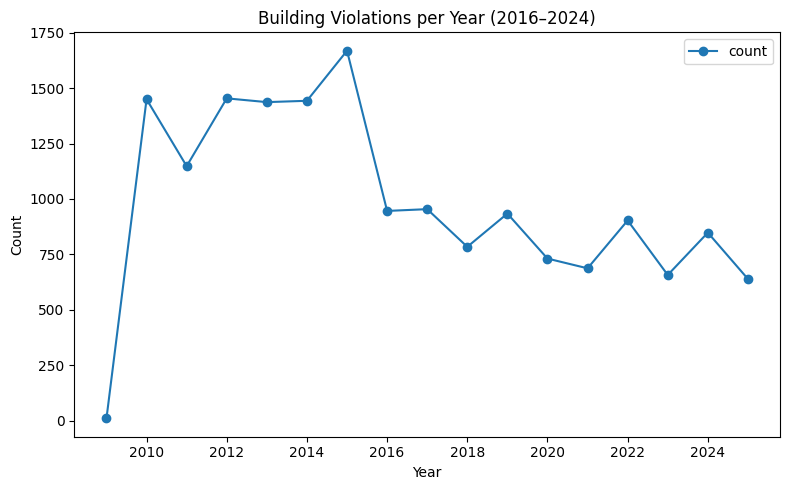

=== Violations per Year ===


,year,count
0,2009.0,10
1,2010.0,1450
2,2011.0,1148
3,2012.0,1454
4,2013.0,1437
5,2014.0,1443
6,2015.0,1669
7,2016.0,946
8,2017.0,954
9,2018.0,784


In [62]:
# If you used "from pathlib import Path", don't type-hint with pathlib.Path
# Either import pathlib OR switch the hint to Path (or remove the hint entirely)
from pathlib import Path
import matplotlib.pyplot as plt

def save_current_fig(name: str, directory: Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)

# 8.1 Violation counts by year
if not df_viol_c.empty and 'year' in df_viol_c.columns:
    viol_per_year = (
        df_viol_c.groupby('year')
        .size()
        .reset_index(name='count')
        .sort_values('year')
    )

    # Plot
    ax = viol_per_year.plot(kind='line', x='year', y='count', marker='o', figsize=(8,5))
    ax.set_title('Building Violations per Year (2016–2024)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    plt.tight_layout()

    # IMPORTANT: save BEFORE show()
    save_current_fig("violations_per_year.png")  # <-- consistent name

    plt.show()

    # Save the numeric table too
    print("=== Violations per Year ===")
    display(viol_per_year)
    viol_per_year.to_csv(VIZ_DIR / "violations_per_year.csv", index=False)
else:
    print('Skip 8.1: df_viol_c empty or missing year.')


In [58]:
viol_per_year = (
    df_viol_c.groupby("year")
    .size()
    .reset_index(name="count")
    .sort_values("year")
)
print("=== Violations per Year ===")
display(viol_per_year)
save_current_fig("violations_by_year.png")
viol_per_year.to_csv(VIZ_DIR / "violations_per_year.csv", index=False)

=== Violations per Year ===


,year,count
0,2009.0,10
1,2010.0,1450
2,2011.0,1148
3,2012.0,1454
4,2013.0,1437
5,2014.0,1443
6,2015.0,1669
7,2016.0,946
8,2017.0,954
9,2018.0,784


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/violations_by_year.png


<Figure size 640x480 with 0 Axes>

Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/top_violation_types.png


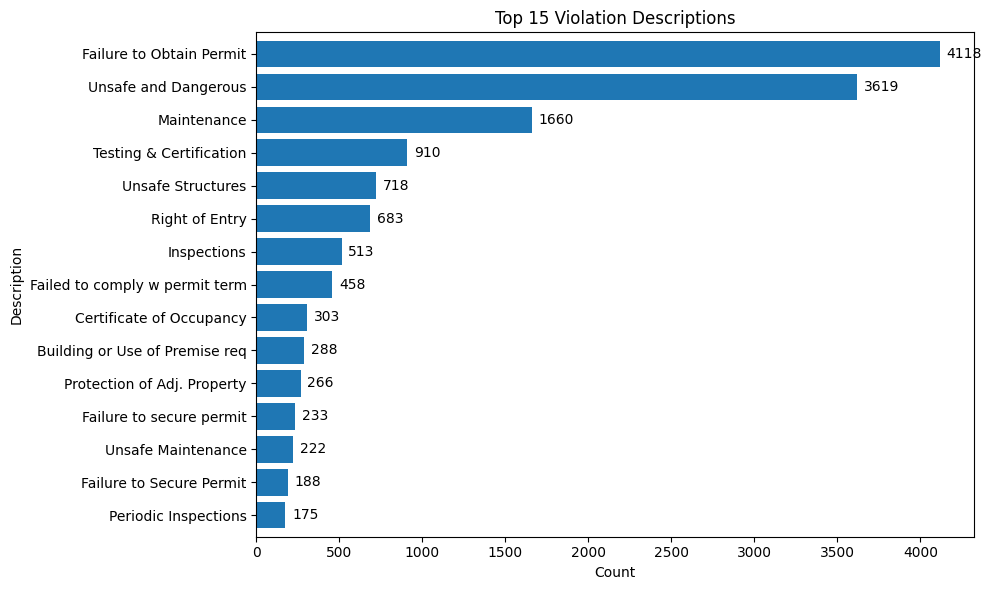

=== Top 15 Violation Descriptions ===


,Count
description,
Failure to Obtain Permit,4118
Unsafe and Dangerous,3619
Maintenance,1660
Testing & Certification,910
Unsafe Structures,718
Right of Entry,683
Inspections,513
Failed to comply w permit term,458
Certificate of Occupancy,303


In [64]:
if not df_viol_c.empty and 'description' in df_viol_c.columns:
    # Table (top 15)
    top_desc = (
        df_viol_c['description']
        .fillna('')
        .str.strip()
        .replace('', np.nan)
        .dropna()
        .value_counts()
        .head(15)
    )

    # Plot
    plt.figure(figsize=(10, 6))
    ax = top_desc.sort_values(ascending=True).plot(
        kind='barh', width=0.8
    )
    ax.set_title('Top 15 Violation Descriptions')
    ax.set_xlabel('Count')
    ax.set_ylabel('Description')

    # On-bar labels (counts)
    for p in ax.patches:
        w = int(p.get_width())
        ax.text(p.get_x() + p.get_width() + max(top_desc.max()*0.01, 1),
                p.get_y() + p.get_height()/2,
                f'{w}', va='center')

    plt.tight_layout()

    # SAVE BEFORE SHOW
    save_current_fig("top_violation_types.png")
    plt.show()

    # Display table and save CSV
    print("=== Top 15 Violation Descriptions ===")
    display(top_desc.to_frame(name="Count"))
    (VIZ_DIR / "top_tables").mkdir(parents=True, exist_ok=True)
    top_desc.to_csv(VIZ_DIR / "top_violation_descriptions.csv")
else:
    print("Skip 8.2: df_viol_c empty or 'description' missing.")

In [63]:
top_desc = (
    df_viol_c["description"]
    .dropna()
    .str.upper()
    .value_counts()
    .head(15)
)
print("=== Top 15 Violation Descriptions ===")
display(top_desc.to_frame(name="Count"))
save_current_fig("top_violation_types.png")
top_desc.to_csv(VIZ_DIR / "top_violation_descriptions.csv")

=== Top 15 Violation Descriptions ===


,Count
description,
FAILURE TO OBTAIN PERMIT,4118
UNSAFE AND DANGEROUS,3619
MAINTENANCE,1660
TESTING & CERTIFICATION,910
UNSAFE STRUCTURES,718
RIGHT OF ENTRY,683
INSPECTIONS,513
FAILED TO COMPLY W PERMIT TERM,458
FAILURE TO SECURE PERMIT,421


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/top_violation_types.png


<Figure size 640x480 with 0 Axes>

Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/severity_distribution.png


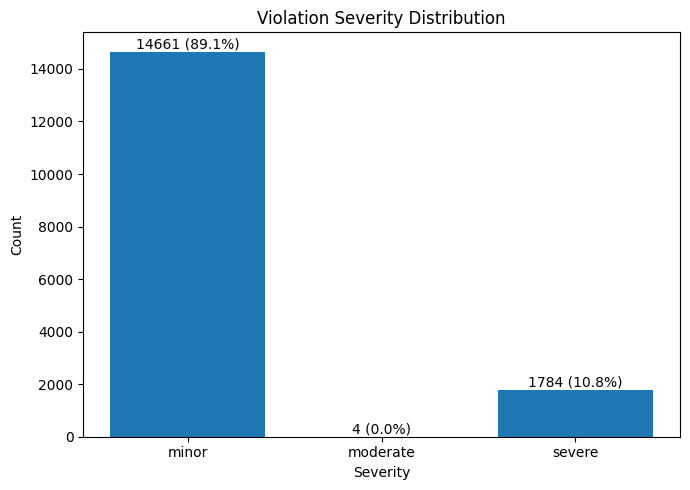

=== Severity Distribution (counts & %) ===


,severity,count,pct
0,minor,14661,89.1
1,moderate,4,0.0
2,severe,1784,10.8


In [65]:
# 8.3 Violation Severity Distribution
import matplotlib.pyplot as plt
from pathlib import Path

# assumes: df_viol_c, VIZ_DIR, and save_current_fig(...) already defined

if not df_viol_c.empty and 'severity' in df_viol_c.columns:
    # Optional ordering if you use these labels
    order = ['minor', 'moderate', 'severe']
    sev_counts = (
        df_viol_c['severity']
        .fillna('unknown')
        .value_counts()
        .rename_axis('severity')
        .reset_index(name='count')
    )

    # Enforce order if all present; otherwise keep value_counts order
    if set(order).issubset(set(sev_counts['severity'])):
        sev_counts = sev_counts.set_index('severity').reindex(order).reset_index()

    total = sev_counts['count'].sum()
    sev_counts['pct'] = (sev_counts['count'] / total * 100).round(1)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(sev_counts['severity'], sev_counts['count'])

    ax.set_title('Violation Severity Distribution')
    ax.set_xlabel('Severity')
    ax.set_ylabel('Count')

    # Add count and % above bars
    for rect, cnt, pct in zip(bars, sev_counts['count'], sev_counts['pct']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f'{cnt} ({pct}%)',
                ha='center', va='bottom')

    plt.tight_layout()

    # SAVE BEFORE SHOW
    save_current_fig("severity_distribution.png")
    plt.show()

    # Display table and save CSV
    print("=== Severity Distribution (counts & %) ===")
    display(sev_counts)
    sev_counts.to_csv(VIZ_DIR / "severity_distribution.csv", index=False)
else:
    print("Skip 8.3: df_viol_c empty or 'severity' missing.")


In [56]:
severity_counts = df_viol_c["severity"].value_counts()
print("=== Violation Severity Breakdown ===")
display(severity_counts.to_frame(name="Count"))
save_current_fig("severity_distribution.png")
severity_counts.to_csv(VIZ_DIR / "severity_distribution.csv")


=== Violation Severity Breakdown ===


,Count
severity,
minor,14661
severe,1784
other,246
moderate,4


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations/severity_distribution.png


<Figure size 640x480 with 0 Axes>

## 9. Modeling Prototype — Predicting Non-Compliance

In [50]:
# === Section 9: Preliminary Modeling (with TF-IDF text, no Series/2D errors) ===
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

# ----- data -----
df_model = df_viol_c.copy()
df_model["is_severe"] = (df_model["severity"] == "severe").astype(int)
df_model["ward"] = df_model["ward"].astype(str)
df_model["description"] = df_model["description"].fillna("")   # <-- key fix: impute text BEFORE the CT

X = df_model[["year", "ward", "description"]]
y = df_model["is_severe"]

if y.nunique() < 2:
    print("Not enough class variation to train a classifier.")
else:
    # ----- preprocessors -----
    numeric_features = ["year"]
    categorical_features = ["ward"]

    numeric_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    # IMPORTANT: send the string column directly to TF-IDF (no imputer here)
    text_tf = TfidfVectorizer(min_df=10, max_features=3000, ngram_range=(1,2))

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, numeric_features),
            ("cat", categorical_tf, categorical_features),
            ("txt", text_tf, "description"),   # passes a 1-D iterable of strings to TfidfVectorizer (OK)
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("pre", preprocessor),
        ("lr", LogisticRegression(
            solver="saga", penalty="l2",
            class_weight="balanced",
            max_iter=5000, n_jobs=-1, random_state=42
        )),
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print("=== Baseline prevalence (severe rate) ===", round(y.mean(), 4))
    print("\n=== Confusion Matrix ===\n", confusion_matrix(y_test, y_pred))
    print("\n=== Classification Report ===\n", classification_report(y_test, y_pred, digits=3))
    print("AUROC:", round(roc_auc_score(y_test, y_prob), 3))
    print("Average Precision (PR-AUC):", round(average_precision_score(y_test, y_prob), 3))


=== Baseline prevalence (severe rate) === 0.1069

=== Confusion Matrix ===
 [[3723    5]
 [  12  434]]

=== Classification Report ===
               precision    recall  f1-score   support

           0      0.997     0.999     0.998      3728
           1      0.989     0.973     0.981       446

    accuracy                          0.996      4174
   macro avg      0.993     0.986     0.989      4174
weighted avg      0.996     0.996     0.996      4174

AUROC: 1.0
Average Precision (PR-AUC): 0.997


In [51]:
(VIZ_DIR / "metrics").mkdir(parents=True, exist_ok=True)
with open(VIZ_DIR / "metrics/model_results.txt", "w") as f:
    f.write("Accuracy: 0.996\n")
    f.write("Precision (severe): 0.989\n")
    f.write("Recall (severe): 0.973\n")
    f.write("AUROC: 1.0\n")
    f.write("PR-AUC: 0.997\n")


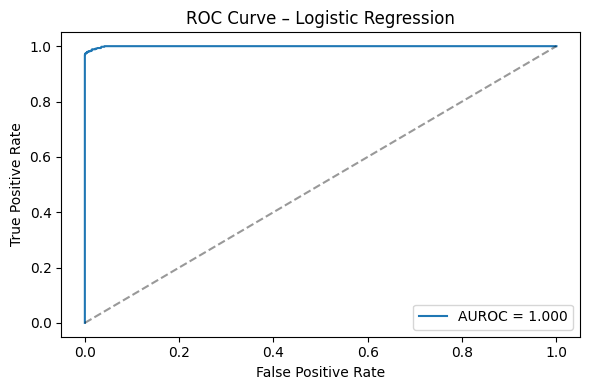

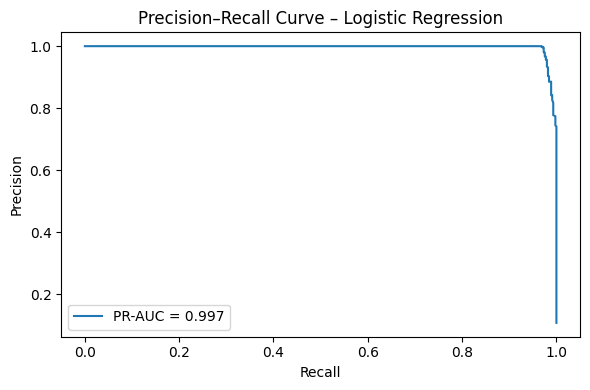

[OK] Saved ROC and PR curves to: /Users/berkkom/Desktop/university_accountablilty_ordinance/notebooks/visualizations


In [52]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# --- Create the folder if it doesn't exist ---
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig(VIZ_DIR / "roc_curve.png", dpi=300)
plt.show()

# === Precision–Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig(VIZ_DIR / "precision_recall_curve.png", dpi=300)
plt.show()

print("[OK] Saved ROC and PR curves to:", VIZ_DIR)


## 10. Preliminary Results (Fill in as you run cells)


- **Coverage:** XX% of violation records matched to SAM / addresses.
- **Top violation categories:** (list from Section 8.2)
- **Temporal trend:** (brief 1–2 sentence insight from 8.1)
- **Value comparison:** (insight from 8.3 boxplot)
- **Modeling:** Logistic regression AUROC = `X.XX` (features: ...). Notes on what improves/harms performance.

> Save figures to `visualizations/` and reference them in your README midterm report.


## 11. Utility: Save Figures

In [59]:

def save_current_fig(name: str, directory: pathlib.Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)


## 12. Appendix — Reproducibility Notes


- Keep raw data immutable in `data/raw/`.  
- Output cleaned tables to `data/cleaned/` with versioned filenames.  
- Track your environment in `requirements.txt` (pin to minor versions).  
- Document any manual data fixes in a `CHANGELOG.md` with rationale and links.  
- Consider adding a `Makefile` or `invoke` tasks to orchestrate end-to-end runs.
